In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from src.unet.datamodules.dm_fast import UNetDataModule

bs = 1
dm = UNetDataModule(batch_size=bs)

dm.setup()

100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


In [5]:
imgs, masks = next(iter(dm.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min()

(torch.Size([1, 3, 512, 512]), torch.float32, tensor(1.), tensor(0.))

In [6]:
masks.shape, masks.dtype, masks.max(), masks.min()

(torch.Size([1, 1, 2048, 2048]), torch.float32, tensor(1.), tensor(0.))

[]

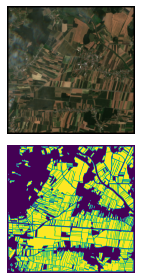

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for ix, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(2, bs, ix + 1)
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax = plt.subplot(2, bs, ix + 1 + bs)
    ax.imshow(mask[0])
    ax.axis('off')
plt.tight_layout()
plt.plot()

In [8]:
from src.unet.model import UNet
import torch 

config = {
    'encoder': 'resnet18'
}

model =  UNet(config)

output = model(torch.randn(4, 3, 512, 512))

output.shape

/home/juan/miniconda3/envs/ai4eo/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([4, 1, 2048, 2048])

## Benchmarking

In [11]:
from src.unet.datamodules.dm_fast import UNetDataModule as dm_fast 
from src.unet.datamodules.dm_slow import UNetDataModule as dm_slow 
import torch.utils.benchmark as benchmark

def load_data(dm):
    for batch_ix, batch in enumerate(dm.train_dataloader()):
        if batch_ix + 1 >= 10:
            break

results = []
batch_sizes = [1, 4, 8, 16, 32]
for batch_size in batch_sizes:
    label = 'Load data'
    sub_label = f'[{batch_size}]'
    dm = dm_fast(batch_size=batch_size)
    dm.setup()
    results.append(benchmark.Timer(
        stmt='load_data(dm)',
        setup='from __main__ import load_data',
        globals={'dm': dm},
        label=label,
        sub_label=sub_label,
        description='fast',
    ).blocked_autorange(min_run_time=1))
    dm = dm_slow(batch_size=batch_size)
    dm.setup()
    results.append(benchmark.Timer(
        stmt='load_data(dm)',
        setup='from __main__ import load_data',
        globals={'dm': dm},
        label=label,
        sub_label=sub_label,
        description='slow',
    ).blocked_autorange(min_run_time=1))

compare = benchmark.Compare(results)
compare.print()

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

[-------- Load data ---------]
           |  fast  |  skimage
1 threads: -------------------
      [1]  |  1.4   |    5.0  
      [2]  |  1.6   |    8.9  

Times are in seconds (s).

